# MNIST DATASET
analysis supported by Hands-on ML by Aurelien Geron

In [3]:
# import data (this is the book)
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
# let's give a look to the arrays
x, y = mnist["data"], mnist["target"]
# x contains 70000 images, where each of them is defined by 784 pixels (square matrix of 28x28)
x.shape

(70000, 784)

In [6]:
type(x)

numpy.ndarray

In [3]:
# y is the array containing the labels (0-9)
y.shape

(70000,)

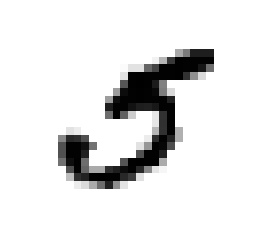

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def image(number):
    some_digit = number.reshape(28, 28)
    plt.imshow(some_digit, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

image(x[36000])

In [5]:
#check if it is a 5 as the image seems to suggest
y[36000]

5.0

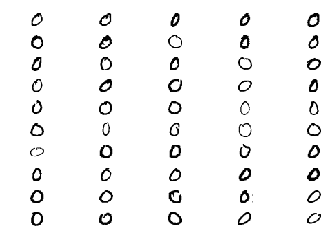

In [15]:
def immagini(data, row, column):
    '''data= subsample of data you want to visualize
    row= number of rows of the image matrix to visualize
    column= columns of the matrix
    '''
    for i in range(row * column):
        # data[i] is i-th image data with size 28x28
        image = data[i].reshape(28, 28)   
        plt.subplot(row, column, i+1)         
        plt.imshow(image, cmap=matplotlib.cm.binary)  
        plt.axis('off')  # do not show axis value
    plt.show()

immagini(x, 10, 5)

#### Train-test split and data shuffle
As the image clearly shows, all MNIST numbers are ordered: first all the zeros of the dataset, then the ones and so on until nine. We need to shuffle our training set, otherwise ML algorithms will underperform and cross-validation won't be feasible.


In [6]:
import numpy as np
# divide train from test set (training dataset size is 60000, and test dataset size is 10000.)
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [8]:
#shuffle data
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
#let's see the results of the shuffle, compared to the previous matrix
immagini(x_train, 10, 5)

### Binary Classifier

In [17]:
# a binary classifier may also distinguish between a certain number and all the others (0, 1)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [18]:
#we can use the classifier to predict an image label as being 5 (or not)
sgd_clf.predict([x_train[5]])

array([False], dtype=bool)

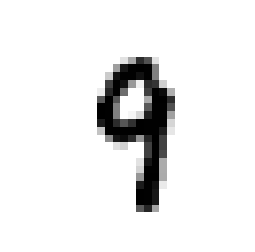

In [19]:
# Is the binary classifier right or wrong?
image(x_train[5])

### Confusion Matrix

In [20]:
#Cross-val_predict() we get the predicted values out of the train set without touching the test set 
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [21]:
# Performance Measures: confusion matrix
from sklearn.metrics import confusion_matrix
#y_train_5 are the target classes and y_train predict the predicted classes
confusion_matrix(y_train_5, y_train_pred)

array([[52185,  2394],
       [ 1938,  3483]], dtype=int64)

In [22]:
#The previous matrix gave us the number of false positive, false negative and true positive/negative. 
#We now can compute out of it the precision and recall of the classifier, or else dicectly use: 
from sklearn.metrics import precision_score, recall_score
#for precision
precision_score(y_train_5, y_train_pred)

0.5926493108728943

In [23]:
#for recall
recall_score(y_train_5, y_train_pred)

0.64250138350857777

In [24]:
#f1 score (combination of precision and recall):
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.61656930430164636

### Precision-recall trade-off
There is a trade-off between precision and recall. The threshold between these two opposite statistics may be switched in line with the needs of the project (you may accept low precision in return high recall for a surveillance system in a supermarket for instance, that is you accept a lot of false allarms in exchange for few false negatives). With a cross_val_predict() function & *decision function* as method we can compute precision and recall for every possible threshold. This way we can visualize their relationship and pick the best trade-off for our project

In [63]:
# Cross-value-prediction specifying decision function as method. 
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [64]:
#this piece of code is because of a specific problem to the version of sklearn 19.0 that I am using
y_scores = y_scores[:, 1]
#check that it is (60000,)
y_scores.shape

(60000,)

In [65]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Create a class of classification plots

In [66]:
class classification_plot:
    
    def __int__(self, precisions, recalls, fpr, tpr, thresholds):
        self.precisions = precisions
        self.recall= recalls
        self.fpr= fpr
        self.tpr= tpr
        self.threshold= threshold
        
    def plot_precision_recall_vs_threshold(self, precisions, recalls, thresholds):
        plt.figure(figsize=(8, 4))
        plt.plot(thresholds, precisions[:-1], "b-.", label="Precision", linewidth=2)
        plt.plot(thresholds, recalls[:-1], "r-", label="Recall", linewidth=2)
        plt.xlabel("Threshold", fontsize=16)
        plt.legend(loc="upper left", fontsize=16)
        plt.xlim([-700000, 700000])
        plt.ylim([0, 1])
    
    def precision_vs_recall(self, precisions, recalls):
        plt.plot(recalls, precisions, "g-", linewidth=2)
        plt.xlabel("Recall", fontsize=16)
        plt.ylabel("Precision", fontsize=16)
        plt.axis([0, 1, 0, 1])
        
    def plot_roc_curve(self, fpr, tpr, label=None):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

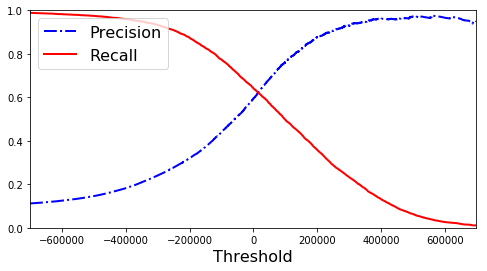

In [68]:
prova= classification_plot()
prova.plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

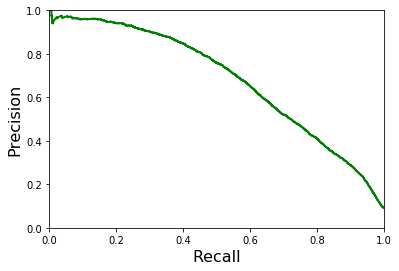

In [69]:
prova.precision_vs_recall(precisions, recalls)

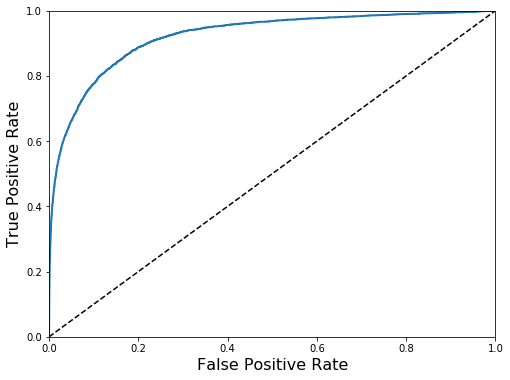

In [70]:
prova.plot_roc_curve(fpr, tpr)

In [36]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
#the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [38]:
# To plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

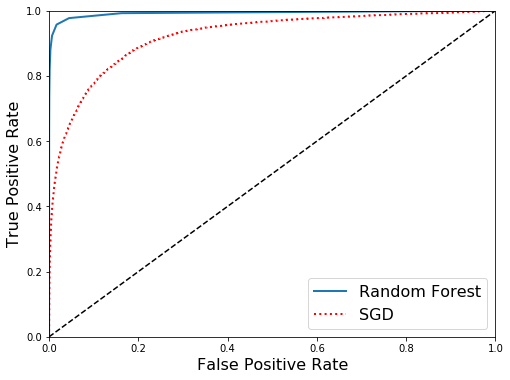

In [39]:
#Plot together the Stochastic Gradient Descent Classifier against the RFClassifier: 
plt.figure(figsize=(8, 6))
prova.plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "r:", linewidth=2, label="SGD")
plt.legend(loc="lower right", fontsize=16)

In [40]:
#the RFC ROC curve is definetely better than the SGDC, as shown by the following statistics
from sklearn.metrics import roc_auc_score
#roc score confirms the visual analysis of the ROC curve
roc_auc_score(y_train_5, y_scores)

0.92166989932317489

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)
#precision 
precision_score(y_train_5, y_train_pred_forest)

0.98385312983853135

In [42]:
#recall
recall_score(y_train_5, y_train_pred_forest)

0.82051282051282048

## Multiclass Classification
Before we just decided with our classifier whether or not a certain number belonged to a certain class: is this pattern of pixels a 5 or not (1 vs 0 = binary)? Now we want to distinguish between more than two classes. Multiclass classifiers may implement one of two major methods to solve the MNIST challenge:
* OvO: one vs one, where we train a classifier for each pair of objects to classify. In this case it's Nx(N-1)/2= 45 classifiers
that is one distinguishing between 0 and 1, another distinguishing between 0 and 2 and so on for all combinations. The advantage here is that you train the classifier on a smaller part of the train data (many classifiers on little data)
* OvA: one vs all, where we train 10 classifiers, one for each number (9 vs all, 8 vs all and so on: less classifiers on more data)


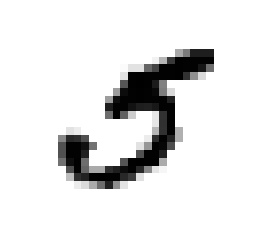

In [46]:
#remeber the image we started with for binary classification
image(x[36000])

In [47]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([x[36000]])

array([ 5.])

In [48]:
some_digit_scores = sgd_clf.decision_function([x[36000]])
#this produces an array with 10 probabilities, one for each 0-9 number, to represent well our image. Note that the highest score
# is the sixth (5)
some_digit_scores

array([[-255418.32304812, -525348.23967083, -373206.35630211,
        -113950.28054962, -412129.78172081,   87945.22377378,
        -730810.56237004, -367920.18874398, -623960.0639257 ,
        -551409.05921795]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
# Scaling the input is an useful trick to improve performance of our classifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
# the output shows a level of accuracy beyond 90%
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91221756,  0.91089554,  0.91003651])

## Error Analysis

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#create the confusion matrix to evaluate your classifier
conf_mx = confusion_matrix(y_train, y_train_pred)

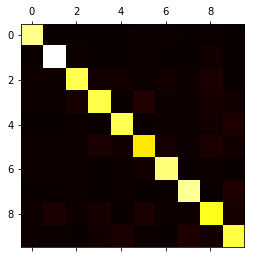

In [88]:
#confusion matrix: most images are on the main diagonal, which means that they were classified correctly
plt.matshow(conf_mx, cmap=plt.cm.hot)

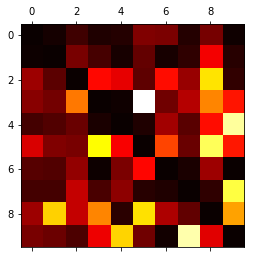

In [87]:
#Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the
# number of images in the corresponding class, so you can compare error rates instead of absolute number
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#Then you have to fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.hot)

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual
classes, while columns represent predicted classes. When the colour is bright we have a substantial misclassification.
For example, 5 (row) gets confused by the algorithm as 3 (column, predicted is very bright). 

## Random Forest Classifier
On the whole dataset, with random search

In [3]:
param_grid = {"n_estimators": [int(i) for i in range(1,30, 3)],
              "max_depth": [None],
              "max_features": [5, 10, 100],
              "min_samples_split": [3, 10],
              "criterion": ["gini", "entropy"]}

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rfclass = RandomForestClassifier(random_state=42)

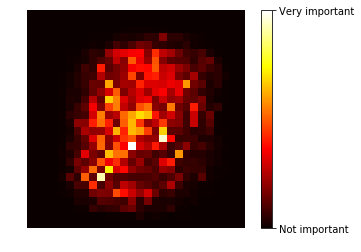

In [19]:
# we can plot the pixel importance of the MNIST dataset using the random forest classifier
rfclass.fit(x_train, y_train)

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(rfclass.feature_importances_)

cbar = plt.colorbar(ticks=[rfclass.feature_importances_.min(), rfclass.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

In [20]:
rfclass.score(x_test, y_test)

0.9476

In [21]:
#apply randomized search
rf_random = RandomizedSearchCV(estimator = rfclass, param_distributions = param_grid, n_iter = 5, cv = 3, random_state=42)
rf_random.fit(x, y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28], 'max_depth': [None], 'max_features': [5, 10, 100], 'min_samples_split': [3, 10], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [24]:
best_random = rf_random.best_estimator_
best_random

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
# Mean accuracy of X wrt y.
rf_random.score(x, y)

0.99968571428571429

In [105]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [21, 22],
              "max_features": [100, 150]}

forest_class_gs = RandomForestClassifier()

grid_search_forest = GridSearchCV(forest_class_gs, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_forest.fit(x, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [21, 22], 'max_features': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [110]:
best_random.score(x, y)

0.99977142857142853

### KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [11]:
y_knn_pred = knn_clf.predict(x_test)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.97140000000000004

In [13]:
from sklearn.model_selection import RandomizedSearchCV
#define your random grid
random_grid = {'n_neighbors': [3,4,5],
               'leaf_size': [15, 30, 50]}

rf_random = RandomizedSearchCV(estimator = knn_clf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#fit the model; uncomment to run (very long)
# rf_random.fit(x, y)